This notebook adds some time & seasonality features to the consumption data, to be used as covariates in the sequence models in notebooks 3.1 and 3.2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import periodogram

In [2]:
output_dir = "./OutputData/"

In [3]:
# Load full data, convert time to datetime
df = pd.read_csv(output_dir + "full_data.csv")
df["time"] = pd.to_datetime(df["time"], format = "%d:%m:%Y:%H:%M")

In [4]:
# Drop generation columns
gen_cols = df.columns.values[2:].tolist()
df = df.drop(gen_cols, axis = 1)

In [5]:
# Real-time consumption is available with a 2 hour lag. Shift it back
df["consumption_lag2"] = df["consumption_MWh"].shift(2)
df = df.dropna()

## Annual periodogram

In [6]:
# Calculate strengths of annual frequencies in consumption time series
p = 365 * 24 # Yearly sampling frequency
freqs, spectrum = periodogram(
    x = df.consumption_MWh.values, 
    fs = p, 
    detrend = "linear",
    scaling = "spectrum"
)

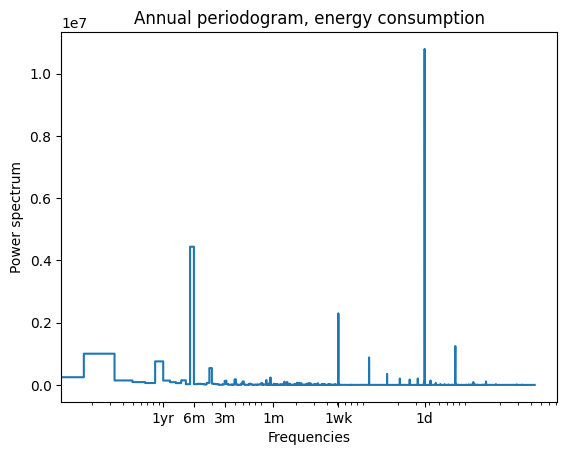

In [7]:
# Plot annual periodogram
fig, ax = plt.subplots()
_ = ax.step(freqs, spectrum)
_ = ax.set_xscale("log")
_ = ax.set_xticks([1, 2, 4, 12, 52, 365])
_ = ax.set_xticklabels(["1yr", "6m", "3m", "1m", "1wk", "1d"])
_ = ax.set_title("Annual periodogram, energy consumption")
_ = ax.set_xlabel("Frequencies")
_ = ax.set_ylabel("Power spectrum")

X-axis corresponds to frequencies: Number of repeats in a year, starting from 1. Y-axis corresponds to the power spectral density of each frequency. 
- A frequency of 1 corresponds to a frequency repeating once per year.
- A frequency of 365 corresponds to a frequency repeating once per day.
- The strongest frequencies are around 2 (biannual seasonality), 52 (day of week seasonality) and 365 (hour of day seasonality).

In [8]:
# Find the exact strongest frequencies
idx_topfreqs = np.argpartition(spectrum, -6)[-6:]
#freqs[idx_topfreqs]
np.round(freqs[idx_topfreqs])

array([104.,   0., 730.,  52., 365.,   2.])

## Cyclical encoding

In [9]:
# Add time columns

# Trend
df["trend"] = df.index.values

# One Fourier pair for each of the strong frequencies

# Bi-yearly frequency
df["biyearly_sin"] = np.sin(2 * np.pi * df["trend"] / p * 2) 
df["biyearly_cos"] = np.cos(2 * np.pi * df["trend"] / p * 2)

# Weekly frequency
df["dayofweek_sin"] = np.sin(2 * np.pi * df["trend"] / p * 52)
df["dayofweek_cos"] = np.cos(2 * np.pi * df["trend"] / p * 52)

# Daily frequency
df["hour_sin"] = np.sin(2 * np.pi * df["trend"] / p * 365)
df["hour_cos"] = np.cos(2 * np.pi * df["trend"] / p * 365)

In [10]:
df

,time,consumption_MWh,consumption_lag2,trend,biyearly_sin,biyearly_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
2,2018-01-01 02:00:00,24635.32,27412.81,2,0.002869,0.999996,0.074526,0.997219,0.500000,8.660254e-01
3,2018-01-01 03:00:00,23872.12,26324.39,3,0.004304,0.999991,0.111659,0.993747,0.707107,7.071068e-01
4,2018-01-01 04:00:00,23194.89,24635.32,4,0.005738,0.999984,0.148637,0.988892,0.866025,5.000000e-01
5,2018-01-01 05:00:00,23071.96,23872.12,5,0.007173,0.999974,0.185408,0.982662,0.965926,2.588190e-01
6,2018-01-01 06:00:00,23267.90,23194.89,6,0.008607,0.999963,0.221922,0.975065,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...
52579,2023-12-31 19:00:00,35090.93,34549.42,52579,0.027252,0.999629,0.650811,0.759240,-0.965926,2.588190e-01
52580,2023-12-31 20:00:00,33310.94,36193.59,52580,0.028686,0.999588,0.678669,0.734444,-0.866025,5.000000e-01
52581,2023-12-31 21:00:00,32083.96,35090.93,52581,0.030120,0.999546,0.705584,0.708627,-0.707107,7.071068e-01
52582,2023-12-31 22:00:00,30469.49,33310.94,52582,0.031554,0.999502,0.731517,0.681823,-0.500000,8.660254e-01


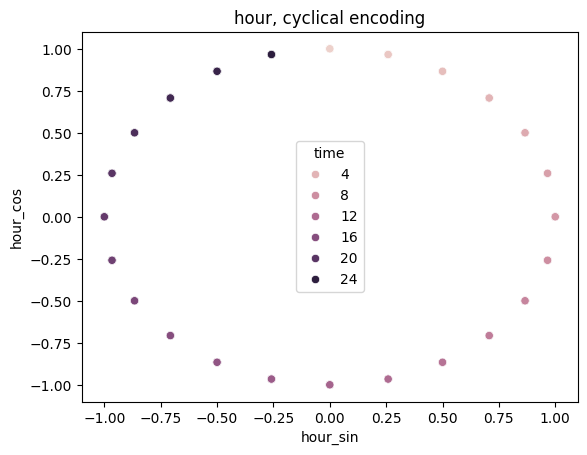

In [11]:
hourofday = df.time.dt.hour + 1
_ = sns.scatterplot(x = df.hour_sin, y = df.hour_cos, hue = hourofday)
_ = plt.title("hour, cyclical encoding")

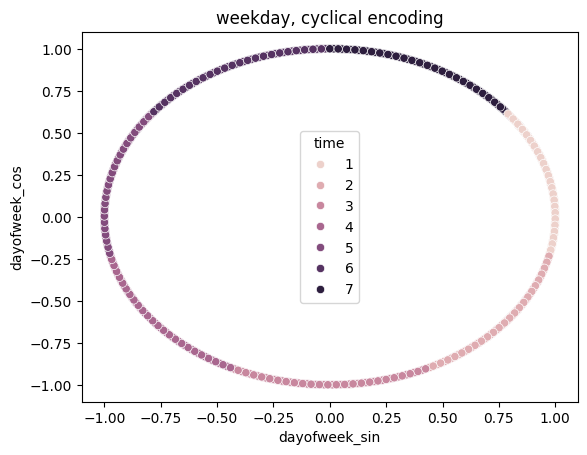

In [12]:
dayofweek = df.time.dt.dayofweek + 1
_ = sns.scatterplot(x = df.dayofweek_sin, y = df.dayofweek_cos, hue = dayofweek)
_ = plt.title("weekday, cyclical encoding")

In [13]:
# Export training data
df.to_csv(output_dir + "train_data.csv", index = False)